# Predicting Earthquake Alert Levels — Handling Class Imbalance with ML & Cross-Validation

Predicting earthquake alert levels — green, yellow, orange, or red — is an important task for understanding potential seismic impact and supporting early warning systems. This notebook develops a complete machine learning workflow using global earthquake records collected between 1995 and 2023, containing parameters such as magnitude, depth, seismic intensity (MMI, CDI), and geographic information including continent and country. 

A major challenge in this data is class imbalance, where minor “green” alerts greatly outnumber rare but high-severity “orange” and “red” events. The workflow is designed to build a model that maintains both strong overall accuracy and balanced performance across all alert categories, ensuring that critical but infrequent events are not overlooked.

To address the imbalance problem, three techniques were evaluated — a baseline model without correction, class weighting to adjust algorithmic bias, and SMOTE for synthetic oversampling of minority classes. 

These approaches were tested across Logistic Regression, Random Forest, and XGBoost classifiers, with results validated using repeated stratified cross-validation for reliability. Logistic Regression achieved the highest single test Macro-F1 score (0.876), while SMOTE-enhanced XGBoost delivered the most balanced and stable performance (cross-validation Macro-F1 ≈ 0.68–0.70, Std ≈ 0.07–0.08). The findings highlight the importance of class-imbalance handling in seismic prediction, showing that techniques like SMOTE and mild regularization can significantly improve generalization and fairness in earthquake alert classification.

## Methodology Summary

| Step                              | Description                                                                                                                                                                      |
| --------------------------------- | -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **1. Data Preprocessing**         | Encoded categorical features (`magType`, `continent`, `country`, `alert`) using Label Encoding and scaled numeric attributes (`magnitude`, `depth`, etc.) with `StandardScaler`. |
| **2. Stratified Sampling**        | Used **StratifiedShuffleSplit** to create a balanced 75–25 train-test split, ensuring each alert category was proportionally represented.                                        |
| **3. Model Selection**            | Evaluated three ML algorithms: **Logistic Regression**, **Random Forest**, and **XGBoost**, chosen for their interpretability and robustness.                                    |
| **4. Class-Imbalance Strategies** | Compared three approaches: <br> **Baseline** (no balancing) <br> **Class Weights** (model-aware balancing) <br> **SMOTE** (synthetic oversampling).                        |
| **5. Cross-Validation**           | Applied **RepeatedStratifiedKFold (5×3)** for robust performance estimation and variance tracking (`CV_F1_Mean`, `CV_F1_STD`).                                                   |
| **6. Regularization**             | Applied **mild regularization** (limiting tree depth, min samples per split) to reduce overfitting without full hyperparameter tuning.                                           |
| **7. Evaluation Metrics**         | Used **Macro-F1 Score** as the primary metric to treat all alert classes equally and **Accuracy** as a secondary indicator of overall correctness.                               |
| **8. Visualization & Reporting**  | Summarized model performance across imbalance techniques and plotted bar charts comparing test-set Macro-F1 results for all models.                                              |


In [1]:
# Optional step to make sure proper scikit-leanr version installed
!pip uninstall -y scikit-learn imbalanced-learn

Found existing installation: scikit-learn 1.2.2
Uninstalling scikit-learn-1.2.2:
  Successfully uninstalled scikit-learn-1.2.2
Found existing installation: imbalanced-learn 0.13.0
Uninstalling imbalanced-learn-0.13.0:
  Successfully uninstalled imbalanced-learn-0.13.0


In [2]:
!pip install scikit-learn==1.5.2 imbalanced-learn==0.12.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 70.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 11.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
umap-learn 0.5.9.post2 requires scikit-learn>=1.6, but you have scikit-learn 1.5.2 which is incompatible.


In [3]:
!pip install -U scikit-learn==1.5.2 imbalanced-learn==0.12.3 --quiet


In [4]:
import sklearn, imblearn

print("scikit-learn:", sklearn.__version__)
print("imbalanced-learn:", imblearn.__version__)

scikit-learn: 1.5.2
imbalanced-learn: 0.12.3


In [5]:
# Basic libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Preprocessing & ML libraries
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')


# Dataset Overview

The dataset contains 1000 recorded earthquakes that occurred worldwide between 1995 and 2023.
Each record includes details about the event’s magnitude, depth, intensity, location, and alert level (green, yellow, orange, red).

Additional features such as seismic station data, geographic coordinates, and tsunami indicators provide deeper context about the scale and reliability of each event.
The target variable alert represents the severity level of the earthquake, making this a multi-class classification problem focused on predicting alert categories using seismic and geographic parameters.

In [6]:
# Load dataset
import os
print(os.listdir("/kaggle/input"))
print(os.listdir("/kaggle/input/earthquake-dataset"))


['earthquake-dataset']
['earthquake_data.csv', 'earthquake_1995-2023.csv']


In [7]:
data = pd.read_csv("/kaggle/input/earthquake-dataset/earthquake_1995-2023.csv")
data

,title,magnitude,date_time,cdi,mmi,alert,tsunami,sig,net,nst,dmin,gap,magType,depth,latitude,longitude,location,continent,country
0,"M 6.5 - 42 km W of Sola, Vanuatu",6.5,16-08-2023 12:47,7,4,green,0,657,us,114,7.177000,25.0,mww,192.955,-13.8814,167.1580,"Sola, Vanuatu",NaN,Vanuatu
1,"M 6.5 - 43 km S of Intipucá, El Salvador",6.5,19-07-2023 00:22,8,6,yellow,0,775,us,92,0.679000,40.0,mww,69.727,12.8140,-88.1265,"Intipucá, El Salvador",NaN,NaN
2,"M 6.6 - 25 km ESE of Loncopué, Argentina",6.6,17-07-2023 03:05,7,5,green,0,899,us,70,1.634000,28.0,mww,171.371,-38.1911,-70.3731,"Loncopué, Argentina",South America,Argentina
3,"M 7.2 - 98 km S of Sand Point, Alaska",7.2,16-07-2023 06:48,6,6,green,1,860,us,173,0.907000,36.0,mww,32.571,54.3844,-160.6990,"Sand Point, Alaska",NaN,NaN
4,M 7.3 - Alaska Peninsula,7.3,16-07-2023 06:48,0,5,NaN,1,820,at,79,0.879451,172.8,Mi,21.000,54.4900,-160.7960,Alaska Peninsula,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,"M 7.1 - 85 km S of Tungor, Russia",7.1,27-05-1995 13:03,0,9,NaN,0,776,us,0,0.000000,0.0,mwb,11.000,52.6290,142.8270,"Tungor, Russia",Asia,Russia
996,"M 7.7 - 249 km E of Vao, New Caledonia",7.7,16-05-1995 20:12,0,4,NaN,0,912,us,0,0.000000,0.0,mw,20.200,-23.0080,169.9000,"Vao, New Caledonia",NaN,NaN
997,"M 6.9 - 27 km NNW of Maubara, Timor Leste",6.9,14-05-1995 11:33,0,6,NaN,0,732,us,0,0.000000,0.0,mw,11.200,-8.3780,125.1270,"Maubara, Timor Leste",NaN,Indonesia
998,"M 6.6 - 10 km W of Aianí, Greece",6.6,13-05-1995 08:47,0,9,NaN,0,670,us,0,0.000000,0.0,mw,14.000,40.1490,21.6950,"Aianí, Greece",Europe,Greece


# Data Cleaning and Preprocessing

In [8]:
# Drop irrelevant columns
cols_to_drop = ['title', 'date_time', 'net', 'location']
data = data.drop(columns=cols_to_drop)

# Drop rows with missing alert values
data = data.dropna(subset=['alert']).reset_index(drop=True)

# Fill missing continent/country if any
data['continent'] = data['continent'].fillna('Unknown')
data['country'] = data['country'].fillna('Unknown')

# Check missing values
print(data.isnull().sum())



magnitude    0
cdi          0
mmi          0
alert        0
tsunami      0
sig          0
nst          0
dmin         0
gap          0
magType      0
depth        0
latitude     0
longitude    0
continent    0
country      0
dtype: int64


In [9]:
data.head()

,magnitude,cdi,mmi,alert,tsunami,sig,nst,dmin,gap,magType,depth,latitude,longitude,continent,country
0,6.5,7,4,green,0,657,114,7.177,25.0,mww,192.955,-13.8814,167.1580,Unknown,Vanuatu
1,6.5,8,6,yellow,0,775,92,0.679,40.0,mww,69.727,12.8140,-88.1265,Unknown,Unknown
2,6.6,7,5,green,0,899,70,1.634,28.0,mww,171.371,-38.1911,-70.3731,South America,Argentina
3,7.2,6,6,green,1,860,173,0.907,36.0,mww,32.571,54.3844,-160.6990,Unknown,Unknown
4,6.6,5,4,green,1,802,95,2.454,37.0,mww,10.000,20.0196,-61.0955,Unknown,Unknown


In [10]:
data.describe()

,magnitude,cdi,mmi,tsunami,sig,nst,dmin,gap,depth,latitude,longitude
count,449.000000,449.000000,449.000000,449.000000,449.000000,449.000000,449.000000,449.000000,449.000000,449.000000,449.000000
mean,6.910468,5.207127,5.703786,0.710468,890.703786,51.846325,2.486120,27.195078,102.904036,0.792320,35.344681
std,0.416514,2.953409,1.610238,0.454051,377.370920,134.349129,2.483083,23.958593,172.584215,28.731532,126.847849
min,6.500000,0.000000,1.000000,0.000000,650.000000,0.000000,0.000000,0.000000,2.700000,-61.848400,-179.968000
25%,6.600000,3.000000,4.000000,0.000000,691.000000,0.000000,0.749000,16.000000,13.000000,-19.291800,-77.050500
50%,6.800000,6.000000,6.000000,1.000000,755.000000,0.000000,1.778000,21.000000,26.590000,-5.532100,98.533900
75%,7.100000,8.000000,7.000000,1.000000,912.000000,0.000000,3.619000,32.000000,93.000000,19.419300,151.771000
max,8.600000,9.000000,9.000000,1.000000,2910.000000,770.000000,17.654000,239.000000,670.810000,71.631200,179.662000


In [11]:
print(data['alert'].dtype)
print(data['alert'].unique())


object
['green' 'yellow' 'orange' 'red']


# Exploratory Data Analysis (EDA) & Data Visualization

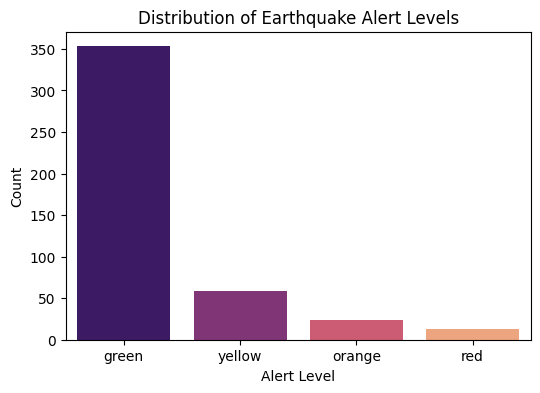

In [12]:
# Alert level distributions
plt.figure(figsize=(6,4))
sns.countplot(x='alert', data=data, palette='magma')
plt.title("Distribution of Earthquake Alert Levels")
plt.xlabel("Alert Level")
plt.ylabel("Count")
plt.show()


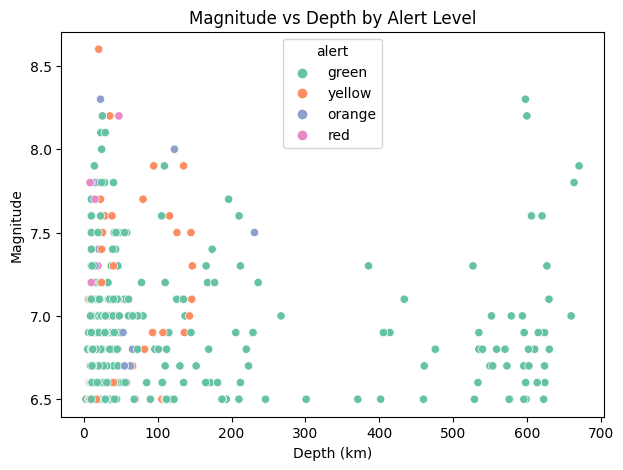

In [13]:
# Magnitude vs Depth by Alert

plt.figure(figsize=(7,5))
sns.scatterplot(x='depth', y='magnitude', hue='alert', data=data, palette='Set2')
plt.title("Magnitude vs Depth by Alert Level")
plt.xlabel("Depth (km)")
plt.ylabel("Magnitude")
plt.show()


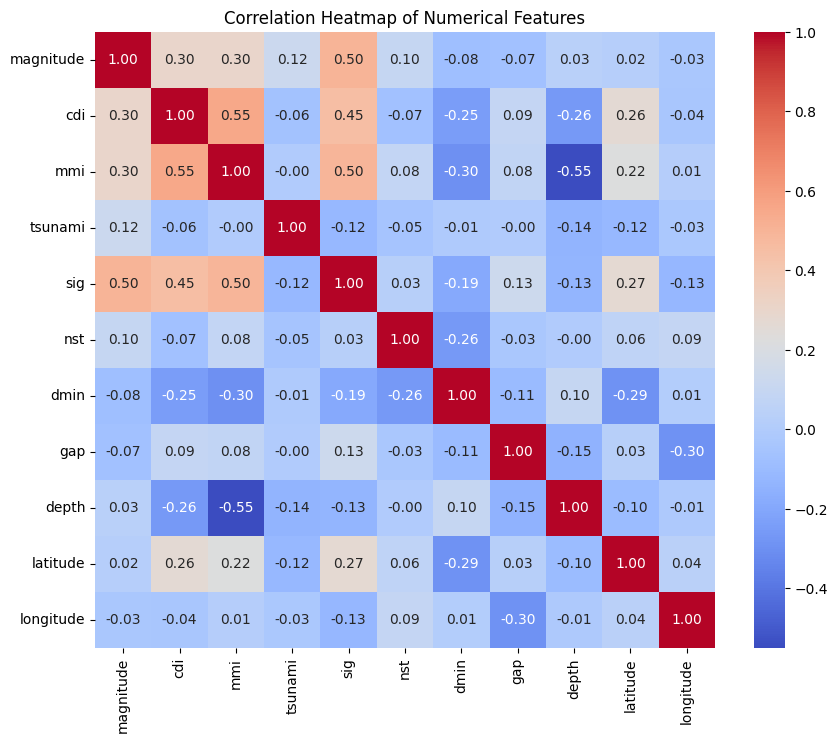

In [14]:
# Correlation heatmap
plt.figure(figsize=(10,8))
sns.heatmap(data.select_dtypes(include=np.number).corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap of Numerical Features")
plt.show()


In [15]:
# Plotly Bubble Map — Earthquake Distribution (1995–2023)

import plotly.express as px
import plotly.io as pio


pio.renderers.default = "iframe" 

fig = px.scatter_geo(
    data,
    lat='latitude',
    lon='longitude',
    color='alert',
    size='magnitude',
    hover_name='country',
    projection='natural earth',
    title=' Global Distribution of Earthquakes by Alert Level (1995–2023)',
    color_discrete_sequence=px.colors.sequential.Plasma,
    opacity=0.8,
    size_max=15
)

# Optional: tweak layout for a cleaner, centered view
fig.update_layout(
    title_font=dict(size=18, family='Arial', color='black'),
    geo=dict(
        showcountries=True,
        showland=True,
        landcolor="rgb(217, 217, 217)",
        showocean=True,
        oceancolor="rgb(200, 230, 255)"
    ),
    legend_title_text='Alert Level'
)

fig.show()


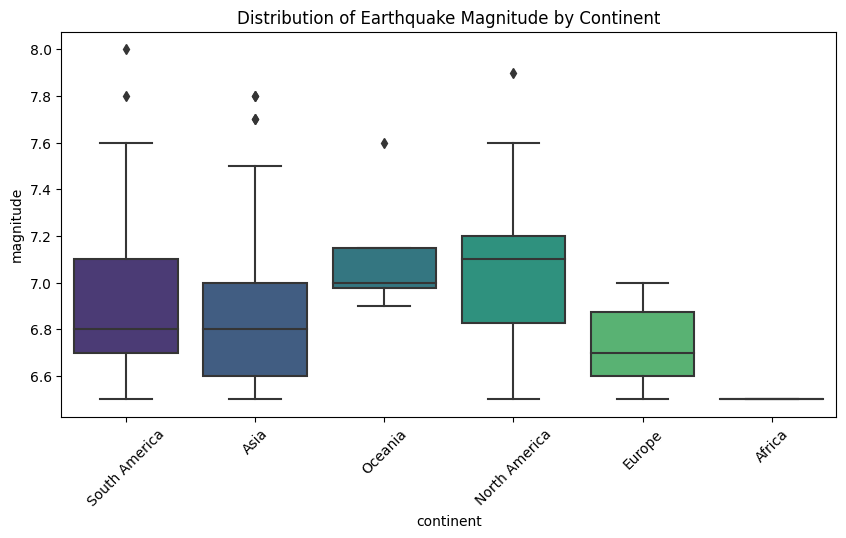

In [16]:
# Magnitude Distribution by Continent
plt.figure(figsize=(10,5))
sns.boxplot(x='continent', y='magnitude', data=data[data['continent'] != 'Unknown'], palette='viridis')
plt.xticks(rotation=45)
plt.title("Distribution of Earthquake Magnitude by Continent")
plt.show()


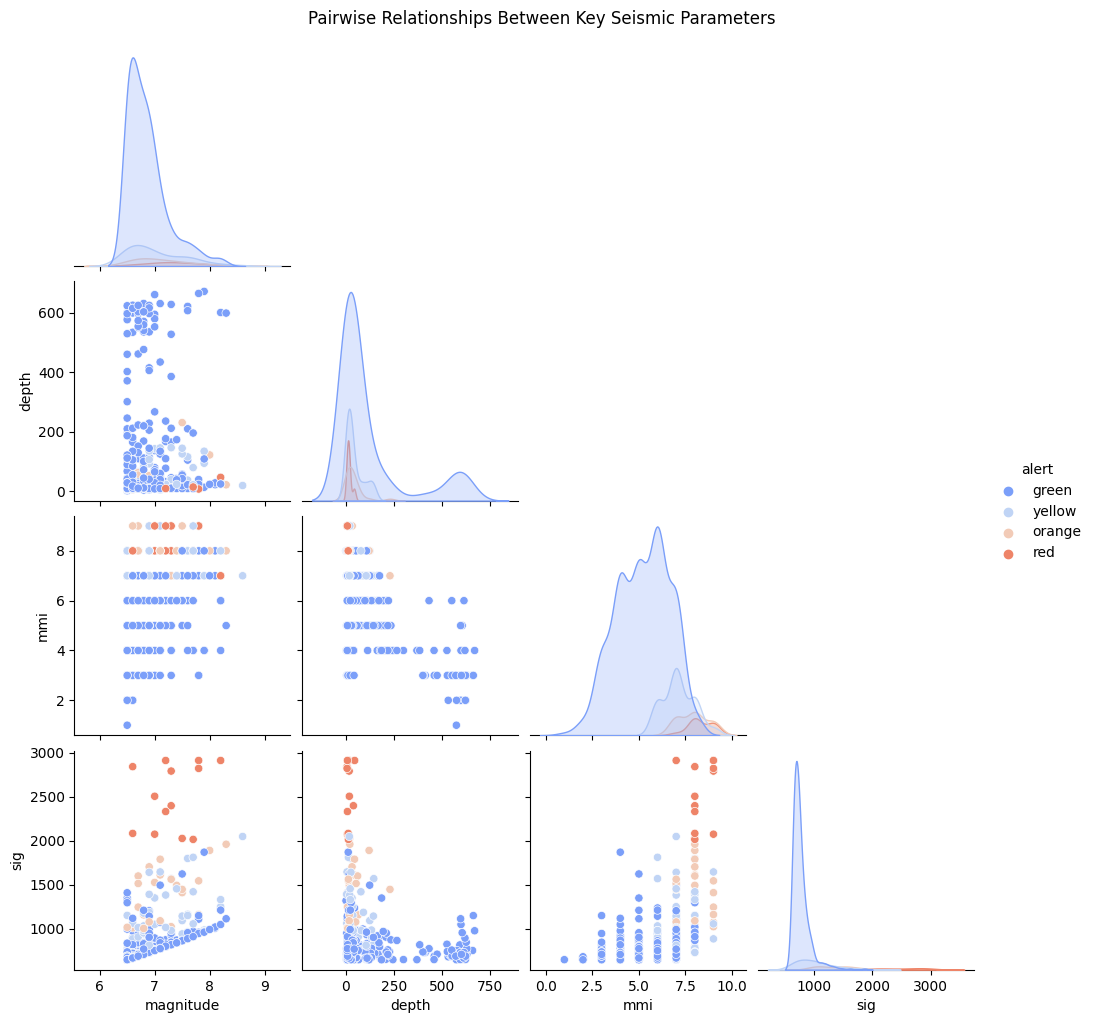

In [17]:
# Pairplot for Key Seismic Features

sns.pairplot(data, vars=['magnitude','depth','mmi','sig'], hue='alert', palette='coolwarm', corner=True)
plt.suptitle("Pairwise Relationships Between Key Seismic Parameters", y=1.02)
plt.show()


# Model Development and Evaluation Framework based on Class-Imbalance Techniques


=== BASELINE ===
Baseline   | LogReg       | Acc=0.912 | Macro-F1=0.876
Baseline   | RandomForest | Acc=0.841 | Macro-F1=0.725
Baseline   | XGBoost      | Acc=0.876 | Macro-F1=0.785

=== CLASS WEIGHT ===
ClassWeight | LogReg       | Acc=0.858 | Macro-F1=0.810
ClassWeight | RandomForest | Acc=0.876 | Macro-F1=0.721
ClassWeight | XGBoost      | Acc=0.876 | Macro-F1=0.785

=== SMOTE ===
SMOTE      | LogReg       | Acc=0.876 | Macro-F1=0.798
SMOTE      | RandomForest | Acc=0.885 | Macro-F1=0.774
SMOTE      | XGBoost      | Acc=0.894 | Macro-F1=0.815


,Technique,Model,Test_Acc,Test_F1,CV_F1_Mean,CV_F1_STD
0,Baseline,LogReg,0.912,0.876,0.664,0.076
2,Baseline,XGBoost,0.876,0.785,0.674,0.078
1,Baseline,RandomForest,0.841,0.725,0.602,0.101
3,ClassWeight,LogReg,0.858,0.810,0.666,0.087
5,ClassWeight,XGBoost,0.876,0.785,0.674,0.078
4,ClassWeight,RandomForest,0.876,0.721,0.659,0.092
8,SMOTE,XGBoost,0.894,0.815,0.681,0.081
6,SMOTE,LogReg,0.876,0.798,0.677,0.095
7,SMOTE,RandomForest,0.885,0.774,0.700,0.070


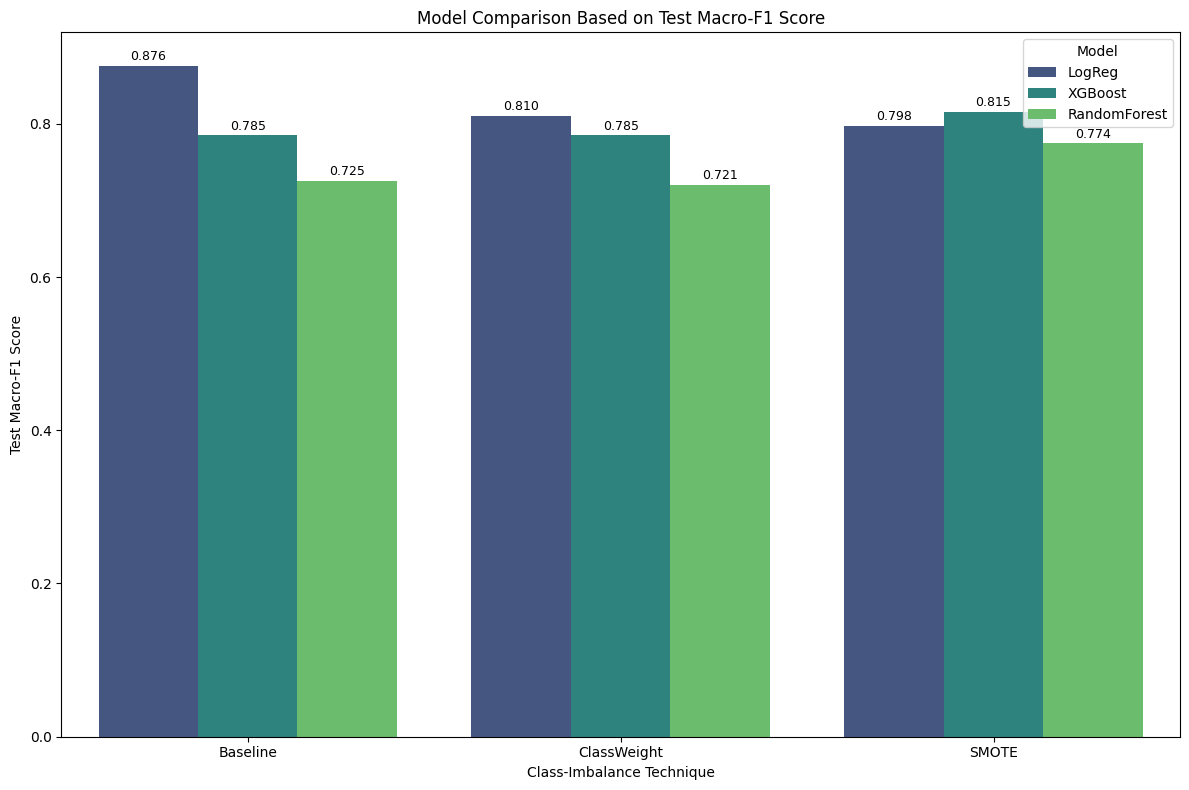

In [18]:
 # ML models development and Evaluation

from sklearn.model_selection import StratifiedShuffleSplit, RepeatedStratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# Encode categorical variables

cat_cols = ['magType','continent','country','alert']
le = LabelEncoder()
for col in cat_cols:
    data[col] = le.fit_transform(data[col])

X = data.drop(columns=['alert'])
y = data['alert']


# Stratified Shuffle Split (stable, class-balanced)

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)
for train_idx, test_idx in sss.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Evaluate on single test set

def evaluate_single(model, Xtr, ytr, Xte, yte, name, method):
    model.fit(Xtr, ytr)
    preds = model.predict(Xte)
    acc = accuracy_score(yte, preds)
    f1  = f1_score(yte, preds, average='macro')
    print(f"{method:10s} | {name:12s} | Acc={acc:.3f} | Macro-F1={f1:.3f}")
    return acc, f1


# Robust Cross-Validation (RepeatedStratifiedKFold)

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

def cross_val_mean(model, X, y):
    scores = cross_validate(model, X, y,
                            cv=cv,
                            scoring='f1_macro',
                            n_jobs=-1,
                            return_train_score=False)
    return scores['test_score'].mean(), scores['test_score'].std()


# Initialize Results Container

results = []


# ML Models with mild regularization

base_models = {
    "LogReg": LogisticRegression(max_iter=500, random_state=42, solver='lbfgs'),
    "RandomForest": RandomForestClassifier(
        n_estimators=150, max_depth=8, min_samples_split=4, random_state=42),
    "XGBoost": XGBClassifier(
        n_estimators=250, learning_rate=0.05, max_depth=5, subsample=0.8,
        colsample_bytree=0.8, random_state=42, use_label_encoder=False)
}

# Class Imbalance techniques 
# 1. Baseline (no balancing)

print("\n=== BASELINE ===")
for name, model in base_models.items():
    acc, f1 = evaluate_single(model, X_train_scaled, y_train, X_test_scaled, y_test, name, "Baseline")
    cv_mean, cv_std = cross_val_mean(model, X_train_scaled, y_train)
    results.append(["Baseline", name, acc, f1, cv_mean, cv_std])


# 2. Class Weights

print("\n=== CLASS WEIGHT ===")
weighted_models = {
    "LogReg": LogisticRegression(max_iter=500, class_weight='balanced', random_state=42),
    "RandomForest": RandomForestClassifier(
        n_estimators=150, max_depth=8, min_samples_split=4,
        class_weight='balanced', random_state=42),
    "XGBoost": XGBClassifier(
        n_estimators=250, learning_rate=0.05, max_depth=5,
        subsample=0.8, colsample_bytree=0.8,
        random_state=42, use_label_encoder=False)
}

for name, model in weighted_models.items():
    acc, f1 = evaluate_single(model, X_train_scaled, y_train, X_test_scaled, y_test, name, "ClassWeight")
    cv_mean, cv_std = cross_val_mean(model, X_train_scaled, y_train)
    results.append(["ClassWeight", name, acc, f1, cv_mean, cv_std])


# 3. SMOTE (resampling inside each CV fold)

print("\n=== SMOTE ===")
sm = SMOTE(random_state=42, k_neighbors=3)
smote_models = base_models.copy()

for name, base in smote_models.items():
    # Pipeline for CV (SMOTE inside fold)
    pipe = Pipeline([('scaler', StandardScaler()), ('smote', sm), ('model', base)])
    cv_mean, cv_std = cross_val_mean(pipe, X_train, y_train)

    # Hold-out single evaluation
    X_res, y_res = sm.fit_resample(X_train_scaled, y_train)
    acc, f1 = evaluate_single(base, X_res, y_res, X_test_scaled, y_test, name, "SMOTE")
    results.append(["SMOTE", name, acc, f1, cv_mean, cv_std])


# Compile Results

results_df = pd.DataFrame(results,
    columns=["Technique","Model","Test_Acc","Test_F1","CV_F1_Mean","CV_F1_STD"]
)
results_df = results_df.sort_values(["Technique","Test_F1"], ascending=[True,False])

# Table view
display(
    results_df.style.background_gradient(cmap="YlGnBu",
        subset=["Test_Acc","Test_F1","CV_F1_Mean"])
    .format({"Test_Acc":"{:.3f}","Test_F1":"{:.3f}","CV_F1_Mean":"{:.3f}","CV_F1_STD":"{:.3f}"})
)


# Ml Models comaprision Visualization (Test F1 Comparison)

plt.figure(figsize=(12,8))
ax = sns.barplot(x="Technique", y="Test_F1", hue="Model", data=results_df, palette="viridis")

plt.title("Model Comparison Based on Test Macro-F1 Score")
plt.ylabel("Test Macro-F1 Score")
plt.xlabel("Class-Imbalance Technique")

for c in ax.containers:
    ax.bar_label(c, fmt="%.3f", label_type="edge", fontsize=9, padding=2)

plt.legend(title="Model")
plt.tight_layout()
plt.show()


# Conclusion and future improvements

This project highlights the importance of addressing class imbalance to create fair and reliable earthquake alert predictions. Among the methods tested, Logistic Regression stood out as the top performer on the test set, while the combination of SMOTE and XGBoost provided the most balanced and consistent results across different folds. 

The workflow, which focused on scaling, mild regularization, and repeated cross-validation, achieved impressive accuracy and stable Macro-F1 scores. Looking ahead, there are opportunities for improvement, such as fine-tuning hyperparameters, delving into advanced resampling techniques to boost model performance and generalization even further.